# Fit double components

In this notebook we will create a syntehtic SN3 spectrum with two Halpha components. We will then fit spectrum and plot the fit.


In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from  scipy import interpolate
import LUCI.LuciFit as lfit
import keras

In [2]:
# Create first spectrum
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
fit_function = 'sincgauss'
ampls = [2, 1, 0.3, 0.15, 0.25]  # Just randomly choosing these
velocity = 0  # km/s
broadening = 10  # km/s
filter_ = 'SN3'
resolution = 5000
snr = 100

spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

In [3]:
# Now create the second spectrum and add them together
lines = ['Halpha']
ampls = [5]  # Just randomly chosen
velocity = 200  # km/s

spectrum_axis2, spectrum2 = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

# Add them together
spectrum += spectrum2


In [4]:
# And we can now take a look

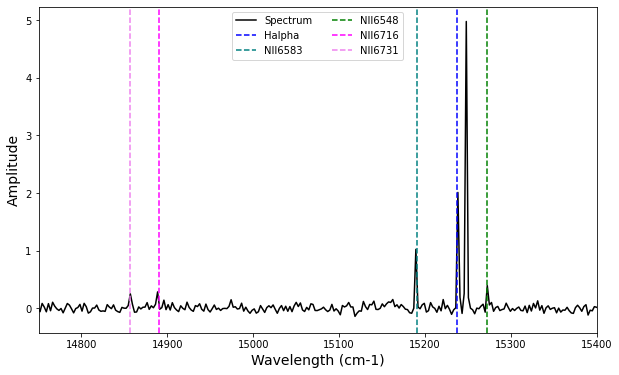

In [5]:
plt.figure(figsize=(10,6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7/656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7/658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7/654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7/671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7/673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

We can clearly see that something is up with the Halpha line (because wd threw a second one there of course). Next, we can fit the components.

In [6]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('/home/carterrhea/Documents/LUCI/ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]
f = interpolate.interp1d(spectrum_axis, spectrum, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale

In [14]:
fit = lfit.Fit(spectrum, spectrum_axis, wavenumbers_syn, 'sincgauss', 
               #['Halpha', 'Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               #[1,2,1,1,1,1], [1,2,1,1,1,1],
               ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], 
               [1,1,1,1,1], [1,1,1,1,1], 
               keras.models.load_model('/home/carterrhea/Documents/LUCI/ML/R5000-PREDICTOR-I-SN3'),
               
                 )
fit_dict = fit.fit()


     fun: 1801.6663241137958
     jac: array([-3.56903076e-02,  5.87310791e-01, -9.57641602e-01, -3.94502869e+01,
        2.72125244e-01,  1.03463745e+00,  1.18505859e+02, -7.60467529e-01,
       -5.38635254e-02,  1.39160156e-02, -1.28753662e-01, -5.61523438e-03,
        6.05621338e-02,  1.03454590e-02, -1.52282715e-02,  1.94790649e+00])
 message: 'Optimization terminated successfully'
    nfev: 314
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([ 9.57932335e-01,  1.52482701e+04,  5.71222848e-01,  9.32310565e-03,
        1.52005339e+04,  5.71222848e-01,  3.10770188e-03,  1.52826647e+04,
        5.71222848e-01,  1.51472260e-03,  1.48993961e+04,  5.71222848e-01,
       -1.02796940e-03,  1.48675646e+04,  5.71222848e-01,  2.09250216e-03])


In [15]:
fit_dict['velocities']

[-213.8887429858332,
 -213.88874312754433,
 -213.88874287855805,
 -213.8887427118342,
 -213.8887430988861]

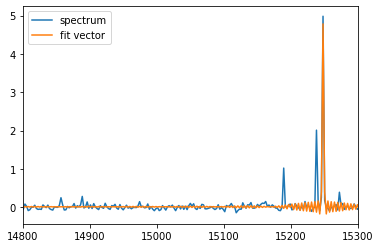

In [16]:
plt.plot(spectrum_axis, spectrum, label='spectrum')
plt.plot(spectrum_axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

In [17]:
fit_dict['amplitudes']

[4.771146849551301,
 0.04643533218436918,
 0.015478444061456403,
 0.007544336569440034,
 -0.005119978496017256]